training_data_size=20, test_data_size8


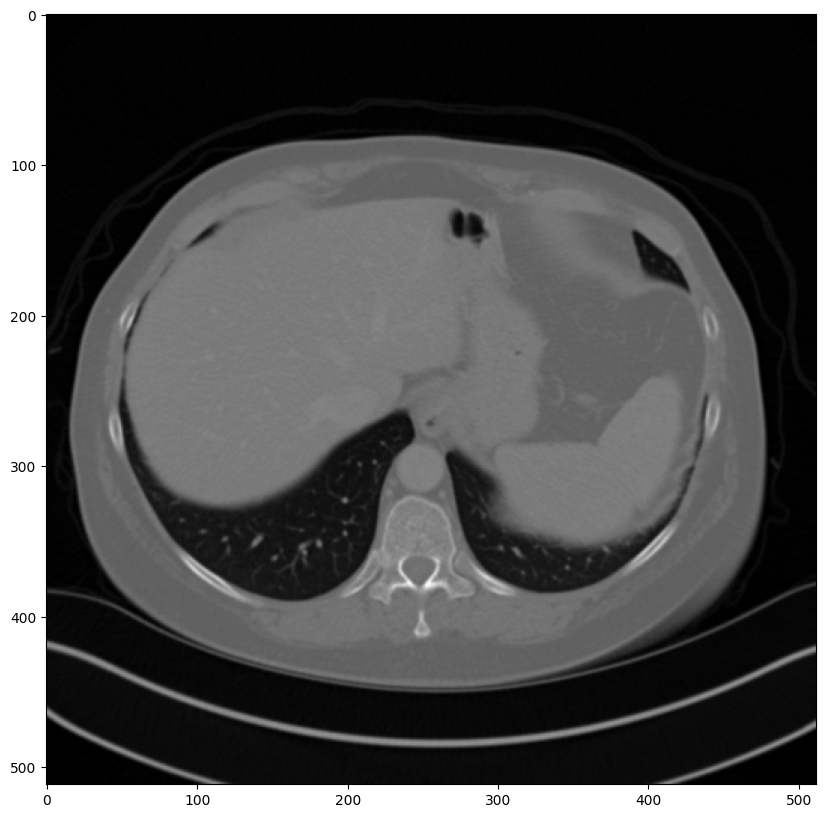

In [21]:
import os
import glob
import warnings
from torch.backends import cudnn
import sys
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
sys.path.append('..')
from classes.dataset_utils.toTorchDataset import ProcessedKit23TorchDataset  
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.utils.data import DataLoader
import sklearn.metrics as metrics
import numpy as np
from torchvision import datasets, transforms
from conv import NetConv

training_data = ProcessedKit23TorchDataset(train_data=True, test_size=0.25)
test_data = ProcessedKit23TorchDataset(train_data=False, test_size=0.25)
print("training_data_size={}, test_data_size{}".format(len(training_data), len(test_data)))
lr = 0.01
epoch = 100
this_case = 1
img, seg = test_data[this_case]

plt.style.use('default')
fig, axs = plt.subplots(figsize=(10,10))
img = img[0,:,:][0,:,:]
axs.imshow(img,cmap="gray")

#data shape is (X, 512, 512)
    
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    conf_matrix = np.zeros((10,10)) # initialize confusion matrix
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            # determine index with maximal log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            # update confusion matrix
            conf_matrix = conf_matrix + metrics.confusion_matrix(
                          target.cpu(),pred.cpu(),labels=[0,1,2,3,4,5,6,7,8,9])
        # print confusion matrix
        np.set_printoptions(precision=4, suppress=True)
        print(type(conf_matrix))
        print(conf_matrix)

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    

    
def main():
    # command-line arguments
    parser = argparse.ArgumentParser()
    parser.add_argument('--net',type=str,default='conv',help='conv is only valid model')
    parser.add_argument('--lr',type=float,default=0.01,help='learning rate')
    parser.add_argument('--mom',type=float,default=0.5,help='momentum')
    parser.add_argument('--epochs',type=int,default=10,help='number of training epochs')
    parser.add_argument('--no_cuda',action='store_true',default=False,help='disables CUDA')
    args = parser.parse_args()

    use_cuda = not args.no_cuda and torch.cuda.is_available()

    device = torch.device('cuda' if use_cuda else 'cpu')

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

    # define a transform to normalize the data
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,))])

    #REPLACE THIS CODE WITH THE LOADING OF OUR DATA SETT AS ABOVE, G, G, G, G,G ,G,G,G,G
    # # fetch and load training data
    # trainset = datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
    # train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=False)
    training_data = ProcessedKit23TorchDataset(train_data=True, test_size=0.25)
    train_loader = torch.utils.data.DataLoader(training_data, batch_size=64, shuffle=False)
    
    torch.utils
    #NEED TO GET THE TRAIN LOADER IN HERE, WHATEVER THAT IS.

    # # fetch and load test data
    # testset = datasets.KMNIST(root='./data', train=False, download=True, transform=transform)
    # test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)
    test_data = ProcessedKit23TorchDataset(train_data=False, test_size=0.25)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

    # choose network architecture
    # if args.net == 'lin':
    #     net = NetLin().to(device)
    # elif args.net == 'full':
    #     net = NetFull().to(device)
    # else:
    net = NetConv().to(device)

    if list(net.parameters()):
        # use SGD optimizer
        optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=args.mom)

        # training and testing loop
        for epoch in range(1, args.epochs + 1):
            train(args, net, device, train_loader, optimizer, epoch)
            test(args, net, device, test_loader)
        
if __name__ == '__main__':
    main()